In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
import os
from numpy.linalg import norm
import joblib as pickle
from tqdm import tqdm
import PIL
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-06-10 10:29:13.563542: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 10:29:13.563639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 10:29:13.680126: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/crop-disease/my_data/Powdery Mildew/cd27fa65-3061-4100-b4a5-e0f84450a398.jpg
/kaggle/input/crop-disease/my_data/Powdery Mildew/06fdfbbf-f026-461b-bcd6-aade28c4fbff.jpg
/kaggle/input/crop-disease/my_data/Powdery Mildew/053ba377-47a1-404f-8ebe-c362997e4190.jpg
/kaggle/input/crop-disease/my_data/Powdery Mildew/09412a28-c575-450e-bcbb-83be6eb56128.jpg
/kaggle/input/crop-disease/my_data/Powdery Mildew/110e76f1-db7d-4c12-9c49-009d04e5287f.jpg
/kaggle/input/crop-disease/my_data/Powdery Mildew/1dbc5a55-4291-4f80-8193-66b382b00b0d.JPG
/kaggle/input/crop-disease/my_data/Powdery Mildew/77cda467-22ca-43ea-99a3-03e609cf3888.jpg
/kaggle/input/crop-disease/my_data/Powdery Mildew/904c477a-ee9a-4443-836c-e296c04ee0b1.jpg
/kaggle/input/crop-disease/my_data/Powdery Mildew/afad9945-6c5b-4755-b14a-70a062d45795.jpg
/kaggle/input/crop-disease/my_data/Powdery Mildew/f4b0fdf7-0b1f-4fbe-a0e8-d7c1aca05d71.jpg
/kaggle/input/crop-disease/my_data/Powdery Mildew/9c101dec-add7-45d0-a24f-45909fdacafc.JPG

In [2]:
img_size = 224

In [3]:
model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3), pooling='max')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
batch_size = 64

In [5]:
root_dir = '/kaggle/input/crop-disease/my_data'

In [6]:
img_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
datagen = img_gen.flow_from_directory(root_dir,
                                      target_size=(img_size, img_size),
                                      batch_size=batch_size,
                                      class_mode=None,
                                      shuffle=False)

num_images = len(datagen.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

Found 3733 images belonging to 20 classes.


In [8]:
feature_list = model.predict(datagen, num_epochs)
print("Num images   = ", len(datagen.classes))
print("Shape of feature_list = ", feature_list.shape)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 2/59 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step  

I0000 00:00:1718015381.554934      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/59 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


59/59 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step
Num images   =  3733
Shape of feature_list =  (3733, 2048)


In [9]:
filenames = [root_dir + '/' + s for s in datagen.filenames]

In [10]:
filenames = [os.path.join(root_dir, s) for s in datagen.filenames]

In [11]:
neighbors = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', metric='euclidean')
neighbors.fit(feature_list)

NearestNeighbors(algorithm='ball_tree', metric='euclidean')

In [12]:
img_path = '/kaggle/input/crop-disease/my_data/Blossom End Rot/009194b1-1718-494b-afe3-4609b5482204.jpg'
input_shape = (img_size, img_size, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)
test_img_features = model.predict(preprocessed_img, batch_size=1)
xx, indices = neighbors.kneighbors(test_img_features, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [13]:
def similar_images(indices):
    plt.figure(figsize=(15, 10), facecolor='white')
    plotnumber = 1    
    for index in indices:
        if plotnumber <= len(indices):
            ax = plt.subplot(2, 4, plotnumber)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')            
            plotnumber += 1
    plt.tight_layout()

print(indices.shape)

(1, 3)


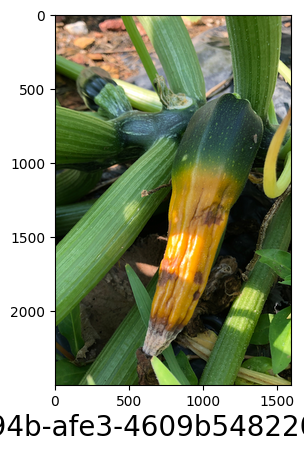

********* Predictions ***********


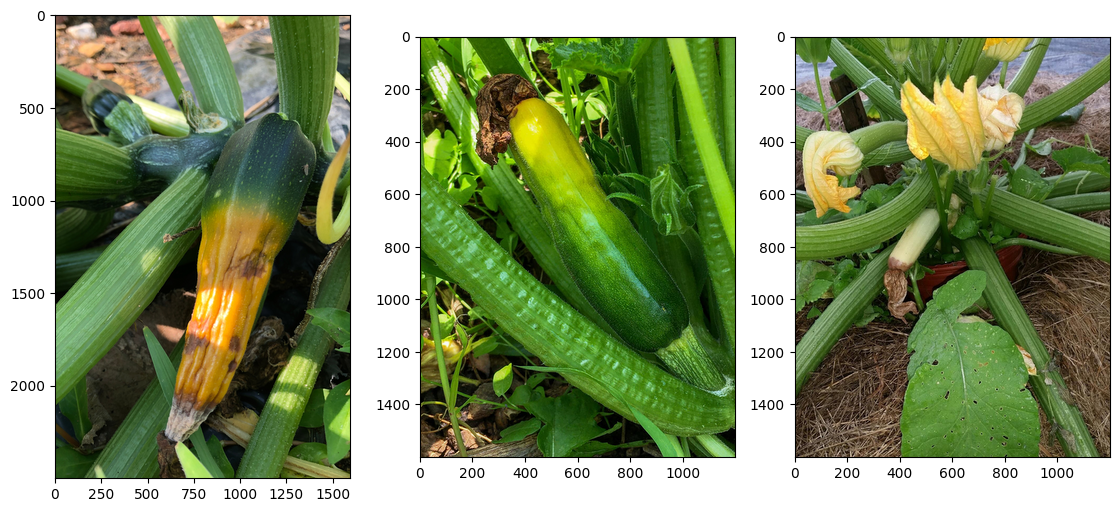

In [14]:
plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('/')[-1] + '_Original Image', fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])